In [1]:
import os
import requests
from dotenv import load_dotenv
from cryptography.hazmat.primitives import serialization
from cryptography.hazmat.backends import default_backend
import base64
from cryptography.hazmat.primitives import hashes
from cryptography.hazmat.primitives.asymmetric import padding, rsa
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
def parse_timestamp(ts):
    """Convert MM/DD/YYYY [HH:MM:SS] to Unix timestamp (int)."""
    if isinstance(ts, str):
        for fmt in ("%m/%d/%Y %H:%M:%S", "%m/%d/%Y %H:%M", "%m/%d/%Y"):
            try:
                return int(datetime.strptime(ts, fmt).timestamp())
            except ValueError:
                continue
        raise ValueError(f"Invalid timestamp format: {ts}")
    return ts  # assume already in correct format if not string


def format_timestamp(ts):
    """Convert Unix timestamp (int) to MM/DD/YYYY HH:MM:SS."""
    if isinstance(ts, (int, float)):
        return datetime.fromtimestamp(ts).strftime("%m/%d/%Y %H:%M:%S")
    elif isinstance(ts, str):
        try:
            ts = float(ts)
            return datetime.fromtimestamp(ts).strftime("%m/%d/%Y %H:%M:%S")
        except ValueError:
            raise ValueError(f"Invalid timestamp: {ts}")
    else:
        raise TypeError(f"Unsupported type for timestamp: {type(ts)}")


# Helper to generate headers for authentication
# Uses RSA-PSS to sign the message composed of timestamp, method, and path
def sign_request(method: str, full_path: str):
    timestamp = str(int(__import__('time').time() * 1000))
    msg = timestamp + method.upper() + full_path
    signature = base64.b64encode(
        PRIVATE_KEY.sign(
            msg.encode('utf-8'),
            padding.PSS(
                mgf=padding.MGF1(hashes.SHA256()),
                salt_length=padding.PSS.DIGEST_LENGTH
            ),
            hashes.SHA256()
        )
    ).decode('utf-8')

    headers = {
        'KALSHI-ACCESS-KEY': KEY_ID,
        'KALSHI-ACCESS-TIMESTAMP': timestamp,
        'KALSHI-ACCESS-SIGNATURE': signature,
        'accept': 'application/json',
        'content-type': 'application/json'
    }
    return headers


# Generic HTTP methods

# Generic GET request
# `endpoint` should be like '/communications/id'
# `params` is a dictionary of URL parameters
def kalshi_get(endpoint, params=None):
    full_path = "/trade-api/v2" + endpoint  # for signing
    url = BASE_URL + endpoint               # for actual request
    headers = sign_request("GET", full_path)
    response = requests.get(url, headers=headers, params=params)
    response.raise_for_status()
    return response.json()

# Generic POST request
# `body` is a JSON-serializable dictionary
def kalshi_post(endpoint, body=None):
    full_path = "/trade-api/v2" + endpoint
    url = BASE_URL + endpoint
    headers = sign_request("POST", full_path)
    response = requests.post(url, headers=headers, json=body)
    response.raise_for_status()
    return response.json() if response.content else {}

# Generic PUT request
# Used for actions like confirming or accepting quotes
def kalshi_put(endpoint, body=None):
    full_path = "/trade-api/v2" + endpoint
    url = BASE_URL + endpoint
    headers = sign_request("PUT", full_path)
    response = requests.put(url, headers=headers, json=body)
    response.raise_for_status()
    return response.json() if response.content else {}

# Generic DELETE request
# Deletes the resource at the endpoint (quote, RFQ, etc.)
def kalshi_delete(endpoint):
    full_path = "/trade-api/v2" + endpoint
    url = BASE_URL + endpoint
    headers = sign_request("DELETE", full_path)
    response = requests.delete(url, headers=headers)
    response.raise_for_status()
    return response.status_code


# ========== Communications API Wrappers ==========

def get_api_version():
    """Returns the version of the Kalshi API currently in use."""
    return kalshi_get("/api_version")

def get_communications_id():
    """Returns the communications ID of the logged-in user."""
    return kalshi_get("/communications/id")

def get_quotes():
    """Returns all quotes visible to the user."""
    return kalshi_get("/communications/quotes")

def create_quote(rfq_id, yes_bid=None, no_bid=None, rest_remainder=False):
    """Creates a quote for an existing RFQ.
    Args:
        rfq_id (str): The RFQ ID you're responding to.
        yes_bid (int): Price in cents you're willing to pay for 'yes'.
        no_bid (int): Price in cents you're willing to pay for 'no'.
        rest_remainder (bool): Whether to leave rest of quantity available.
    """
    body = {
        "rfq_id": rfq_id,
        "yes_bid": yes_bid,
        "no_bid": no_bid,
        "rest_remainder": rest_remainder
    }
    return kalshi_post("/communications/quotes", body)

def get_quote(quote_id):
    """Retrieves a specific quote by ID."""
    return kalshi_get(f"/communications/quotes/{quote_id}")

def delete_quote(quote_id):
    """Deletes a quote so it can no longer be accepted."""
    return kalshi_delete(f"/communications/quotes/{quote_id}")

def accept_quote(quote_id, accepted_side):
    """Accepts a quote.
    Args:
        quote_id (str): The quote to accept.
        accepted_side (str): 'yes' or 'no'.
    """
    return kalshi_put(f"/communications/quotes/{quote_id}/accept", {"accepted_side": accepted_side})

def confirm_quote(quote_id):
    """Confirms a quote to trigger execution. Should be done after acceptance."""
    return kalshi_put(f"/communications/quotes/{quote_id}/confirm")

def get_rfqs():
    """Returns all RFQs visible to the user."""
    return kalshi_get("/communications/rfqs")

def create_rfq(market_ticker, contracts, rest_remainder=False):
    """Creates a new RFQ.
    Args:
        market_ticker (str): The market ticker you're requesting a quote for.
        contracts (int): The number of contracts to request.
        rest_remainder (bool): Whether the remainder can stay on the book.
    """
    body = {
        "market_ticker": market_ticker,
        "contracts": contracts,
        "rest_remainder": rest_remainder
    }
    return kalshi_post("/communications/rfqs", body)

def get_rfq(rfq_id):
    """Returns a specific RFQ by ID."""
    return kalshi_get(f"/communications/rfqs/{rfq_id}")

def delete_rfq(rfq_id):
    """Deletes an RFQ by ID."""
    return kalshi_delete(f"/communications/rfqs/{rfq_id}")

def get_events(limit=100, cursor=None, status=None, series_ticker=None, with_nested_markets=False):
    """
    Get a list of events with optional filtering.

    Parameters:
        limit (int): Max number of results (1-200)
        cursor (str): Used for pagination
        status (str): Filter events by status: unopened, open, closed, settled
        series_ticker (str): Filter events by series
        with_nested_markets (bool): Include nested market objects
    """
    params = {
        "limit": limit,
        "cursor": cursor,
        "status": status,
        "series_ticker": series_ticker,
        "with_nested_markets": with_nested_markets
    }
    return kalshi_get("/events", {k: v for k, v in params.items() if v is not None})

def get_event(event_ticker, with_nested_markets=False):
    """
    Get details for a specific event.

    Parameters:
        event_ticker (str): The event identifier
        with_nested_markets (bool): Include related markets
    """
    return kalshi_get(f"/events/{event_ticker}", {"with_nested_markets": with_nested_markets})

def get_markets(limit=100, cursor=None, event_ticker=None, series_ticker=None,
                max_close_ts=None, min_close_ts=None, status=None, tickers=None):
    """
    Get a list of markets with optional filters.

    Parameters:
        limit (int): Max number of results (1-1000)
        cursor (str): Used for pagination
        event_ticker (str): Filter markets belonging to this event
        series_ticker (str): Filter markets belonging to this series
        max_close_ts (int): Markets closing before this Unix timestamp
        min_close_ts (int): Markets closing after this Unix timestamp
        status (str): Filter by market status: unopened, open, closed, settled
        tickers (str): Comma-separated tickers to filter
    """
    max_close_ts = parse_timestamp(max_close_ts) if max_close_ts else None
    min_close_ts = parse_timestamp(min_close_ts) if min_close_ts else None
    params = {
        "limit": limit,
        "cursor": cursor,
        "event_ticker": event_ticker,
        "series_ticker": series_ticker,
        "max_close_ts": max_close_ts,
        "min_close_ts": min_close_ts,
        "status": status,
        "tickers": tickers
    }
    return kalshi_get("/markets", {k: v for k, v in params.items() if v is not None})

def get_market(ticker):
    """
    Get market details by market ticker.

    Parameters:
        ticker (str): Market ticker
    """
    return kalshi_get(f"/markets/{ticker}")

def get_market_orderbook(ticker, depth=None):
    """
    Retrieve the order book for a given market.

    Parameters:
        ticker (str): Market ticker
        depth (int): Max number of levels per side (optional)
    """
    params = {"depth": depth} if depth else None
    return kalshi_get(f"/markets/{ticker}/orderbook", params)

def get_trades(ticker=None, limit=100, cursor=None, min_ts=None, max_ts=None):
    """
    Get trade history for one or more markets.

    Parameters:
        ticker (str): Specific market ticker
        limit (int): Max number of trades to retrieve
        cursor (str): Pagination cursor
        min_ts (int): Minimum timestamp (Unix time)
        max_ts (int): Maximum timestamp (Unix time)
    """
    min_ts = parse_timestamp(min_ts) if min_ts else None
    max_ts = parse_timestamp(max_ts) if max_ts else None
    params = {
        "ticker": ticker,
        "limit": limit,
        "cursor": cursor,
        "min_ts": min_ts,
        "max_ts": max_ts
    }
    return kalshi_get("/markets/trades", {k: v for k, v in params.items() if v is not None})

def get_series_list(category=None, include_product_metadata=False):
    """
    Get a list of series optionally filtered by category.

    Parameters:
        category (str): Filter series by category
        include_product_metadata (bool): Include metadata
    """
    params = {
        "category": category,
        "include_product_metadata": include_product_metadata
    }
    return kalshi_get("/series/", {k: v for k, v in params.items() if v is not None})

def get_series(series_ticker):
    """
    Get a specific series by its ticker.

    Parameters:
        series_ticker (str): The series identifier
    """
    return kalshi_get(f"/series/{series_ticker}")

def get_market_candlesticks(series_ticker, ticker, start_ts, end_ts, period_interval):
    """
    Retrieve historical candlestick data for a market.

    Parameters:
        series_ticker (str): The series the market belongs to
        ticker (str): The market ticker
        start_ts (int): Unix timestamp for beginning of range
        end_ts (int): Unix timestamp for end of range
        period_interval (int): Time per candle in minutes (1, 60, or 1440)
    """
    start_ts = parse_timestamp(start_ts)
    end_ts = parse_timestamp(end_ts)
    params = {
        "start_ts": start_ts,
        "end_ts": end_ts,
        "period_interval": period_interval
    }
    return kalshi_get(f"/series/{series_ticker}/markets/{ticker}/candlesticks", params)

# ========== Exchange API Wrappers ==========

def get_exchange_announcements():
    """
    Retrieve all exchange-wide announcements.

    Returns:
        List of announcement objects with timestamps and message details.
    """
    return kalshi_get("/exchange/announcements")

def get_exchange_schedule():
    """
    Retrieve the current exchange operating schedule.

    Returns:
        Schedule object with daily hours and trading availability.
    """
    return kalshi_get("/exchange/schedule")

def get_exchange_status():
    """
    Retrieve the current operational status of the exchange.

    Returns:
        Status object including live or maintenance info.
    """
    return kalshi_get("/exchange/status")

def get_user_data_timestamp():
    """
    Retrieve the timestamp of the last backend data update for user-specific views.
    Useful for syncing between API fetches and websocket updates.

    Returns:
        Object with keys like "orders_ts", "positions_ts", etc.
    """
    return kalshi_get("/exchange/user_data_timestamp")

# ========== Milestones API Wrappers ==========

def get_milestones(limit, minimum_start_date=None, category=None, type=None, related_event_ticker=None, cursor=None):
    """
    Retrieve a list of milestones, with optional filters.

    Parameters:
        limit (int): Number of results (1 to 500) — required.
        minimum_start_date (str): ISO format datetime to filter by start date.
        category (str): Filter milestones by category.
        type (str): Filter milestones by type.
        related_event_ticker (str): Filter by related event.
        cursor (str): Pagination cursor.

    Returns:
        List of milestone metadata.
    """
    params = {
        "limit": limit,
        "minimum_start_date": minimum_start_date,
        "category": category,
        "type": type,
        "related_event_ticker": related_event_ticker,
        "cursor": cursor
    }
    return kalshi_get("/milestones/", {k: v for k, v in params.items() if v is not None})

def get_milestone(milestone_id):
    """
    Retrieve details for a specific milestone by its ID.

    Parameters:
        milestone_id (str): Unique milestone identifier.

    Returns:
        Milestone details.
    """
    return kalshi_get(f"/milestones/{milestone_id}")

# ========== Multivariate Collections API Wrappers ==========

def get_event_collections(status=None, associated_event_ticker=None, series_ticker=None, limit=100, cursor=None):
    """
    Retrieve multivariate event collections.

    Parameters:
        status (str): Filter collections by status (unopened, open, closed).
        associated_event_ticker (str): Filter by related event ticker.
        series_ticker (str): Filter by series ticker.
        limit (int): Number of results (1 to 200).
        cursor (str): Pagination cursor.

    Returns:
        List of event collection metadata.
    """
    params = {
        "status": status,
        "associated_event_ticker": associated_event_ticker,
        "series_ticker": series_ticker,
        "limit": limit,
        "cursor": cursor
    }
    return kalshi_get("/multivariate_event_collections/", {k: v for k, v in params.items() if v is not None})

def get_event_collection(collection_ticker):
    """
    Retrieve a specific multivariate event collection.

    Parameters:
        collection_ticker (str): Collection identifier.

    Returns:
        Metadata and structure of the event collection.
    """
    return kalshi_get(f"/multivariate_event_collections/{collection_ticker}")

# ========== Portfolio API Wrappers ==========

def get_balance():
    """Retrieve the current account balance."""
    return kalshi_get("/portfolio/balance")

def get_fills(ticker=None, order_id=None, min_ts=None, max_ts=None, limit=100, cursor=None):
    """Retrieve executed trade fills."""
    min_ts = parse_timestamp(min_ts) if min_ts else None
    max_ts = parse_timestamp(max_ts) if max_ts else None
    params = {
        "ticker": ticker,
        "order_id": order_id,
        "min_ts": min_ts,
        "max_ts": max_ts,
        "limit": limit,
        "cursor": cursor
    }
    return kalshi_get("/portfolio/fills", {k: v for k, v in params.items() if v is not None})

def get_orders(ticker=None, event_ticker=None, min_ts=None, max_ts=None, status=None, limit=100, cursor=None):
    """Retrieve all orders."""
    min_ts = parse_timestamp(min_ts) if min_ts else None
    max_ts = parse_timestamp(max_ts) if max_ts else None
    params = {
        "ticker": ticker,
        "event_ticker": event_ticker,
        "min_ts": min_ts,
        "max_ts": max_ts,
        "status": status,
        "limit": limit,
        "cursor": cursor
    }
    return kalshi_get("/portfolio/orders", {k: v for k, v in params.items() if v is not None})

def get_order(order_id):
    """Retrieve a specific order by ID."""
    return kalshi_get(f"/portfolio/orders/{order_id}")

def create_order(order_data):
    """Submit a new order.

    Args:
        order_data (dict): Must include fields like ticker, side, type, count, and price (yes_price or no_price).

    Returns:
        Confirmation with order ID.
    """
    return kalshi_post("/portfolio/orders", order_data)

def batch_create_orders(order_list):
    """Submit multiple orders in a single request (advanced users only)."""
    return kalshi_post("/portfolio/orders/batched", {"orders": order_list})

def cancel_order(order_id):
    """Cancel a specific order by ID."""
    return kalshi_delete(f"/portfolio/orders/{order_id}")

def batch_cancel_orders(order_ids):
    """Cancel multiple orders by ID (advanced users only)."""
    return kalshi_delete("/portfolio/orders/batched", {"ids": order_ids})

def decrease_order(order_id, reduce_by=None, reduce_to=None):
    """Decrease the number of contracts in an existing order."""
    body = {"reduce_by": reduce_by, "reduce_to": reduce_to}
    return kalshi_post(f"/portfolio/orders/{order_id}/decrease", {k: v for k, v in body.items() if v is not None})

def get_positions(ticker=None, event_ticker=None, count_filter=None, settlement_status="unsettled", limit=100, cursor=None):
    """Get all market positions."""
    params = {
        "ticker": ticker,
        "event_ticker": event_ticker,
        "count_filter": count_filter,
        "settlement_status": settlement_status,
        "limit": limit,
        "cursor": cursor
    }
    return kalshi_get("/portfolio/positions", {k: v for k, v in params.items() if v is not None})

def get_portfolio_settlements(limit=100, min_ts=None, max_ts=None, cursor=None):
    """Retrieve historical portfolio settlements."""
    min_ts = parse_timestamp(min_ts) if min_ts else None
    max_ts = parse_timestamp(max_ts) if max_ts else None
    params = {
        "limit": limit,
        "min_ts": min_ts,
        "max_ts": max_ts,
        "cursor": cursor
    }
    return kalshi_get("/portfolio/settlements", {k: v for k, v in params.items() if v is not None})

def get_total_resting_order_value():
    """Retrieve the total value of resting orders (FCM members only)."""
    return kalshi_get("/portfolio/summary/total_resting_order_value")

# ========== Structured Targets API Wrappers ==========

def get_structured_target(structured_target_id):
    """Retrieve a structured target by ID.

    Args:
        structured_target_id (str): The ID of the structured target.

    Returns:
        JSON response containing structured target metadata.
    """
    return kalshi_get(f"/structured_targets/{structured_target_id}")

In [ ]:
def candlesticks_to_df(candlestick_response):
    """Convert candlestick API response to DataFrame with readable timestamps."""
    rows = []
    for candle in candlestick_response["candlesticks"]:
        row = {
            "end_period": format_timestamp(candle["end_period_ts"]),
            "volume": candle["volume"],
            "open_interest": candle["open_interest"],
        }

        # Flatten nested dictionaries
        for section in ["yes_bid", "yes_ask", "price"]:
            for k, v in candle.get(section, {}).items():
                row[f"{section}_{k}"] = v

        rows.append(row)

    return pd.DataFrame(rows)

import pandas as pd
from datetime import datetime
import mplfinance as mpf

def get_all_markets(status="open", batch_size=1000):
    all_markets = []
    cursor = None
    while True:
        response = get_markets(limit=batch_size, status=status, cursor=cursor)
        all_markets.extend(response["markets"])
        
        cursor = response.get("cursor")  # <==== this is the real fix
        if not cursor:
            break

    return all_markets

def build_candlestick(candlestick_data):
    """Convert Kalshi candlestick API data to DataFrame for plotting."""
    records = []
    for entry in candlestick_data["candlesticks"]:
        row = {
            "Date": datetime.fromtimestamp(entry["end_period_ts"]),
            "Open": entry["price"]["open"] or entry["yes_bid"].get("open"),
            "High": entry["price"]["high"] or entry["yes_bid"].get("high"),
            "Low": entry["price"]["low"] or entry["yes_bid"].get("low"),
            "Close": entry["price"]["close"] or entry["yes_bid"].get("close"),
            "Volume": entry["volume"]
        }
        records.append(row)
    df = pd.DataFrame(records)
    df.set_index("Date", inplace=True)
    return df

In [9]:
"""
Kalshi API Utility Functions
=============================
This module provides signed and authenticated access to the Kalshi Trading API, including tools for working with quotes, RFQs, and account information.
It supports all major HTTP methods (GET, POST, PUT, DELETE) with RSA-based authentication using your Kalshi credentials.

Environment variables required (set in `.env`):
- PROD_KEYID / DEMO_KEYID: Your Kalshi key ID
- PROD_KEYFILE / DEMO_KEYFILE: Path to your RSA private key file
- ENV: Either "PROD" or "DEMO" to toggle environments
"""

# Load environment variables from .env
load_dotenv()

ENVIRONMENT = os.getenv("ENV", "DEMO")
KEY_ID = os.getenv(f"{ENVIRONMENT}_KEYID")
KEY_FILE = os.getenv(f"{ENVIRONMENT}_KEYFILE")
BASE_URL = "https://api.elections.kalshi.com/trade-api/v2" # Production URL
# BASE_URL = "https://demo-api.kalshi.co/trade-api/v2" # Demo URL

# Load private key
with open(KEY_FILE, "rb") as key_file:
    PRIVATE_KEY = serialization.load_pem_private_key(
        key_file.read(),
        password=None,
        backend=default_backend()
    )

In [56]:
from datetime import datetime, timedelta

def get_full_market_candlesticks(series_ticker, ticker, period_interval, start_ts=None, end_ts=None):
    """
    Fetch full historical candlesticks for a market by looping in 5000-period chunks.

    Args:
        series_ticker (str)
        ticker (str)
        start_ts (str or datetime): MM/DD/YYYY or datetime object
        end_ts (str or datetime): MM/DD/YYYY or datetime object
        period_interval (int): Minutes (1, 60, 1440)

    Returns:
        List of all candlestick entries
    """
    if isinstance(period_interval, str):
        period_interval = {"m": 1, "h": 60, "g": 1440}[period_interval.lower()]

    if start_ts is None or end_ts is None:
        market_meta = get_market(ticker)
        if start_ts is None:
            start_ts = datetime.fromisoformat(market_meta['market']['open_time'].replace("Z", "")).replace(tzinfo=None)
        if end_ts is None:
            end_ts = datetime.fromisoformat(market_meta['market']['close_time'].replace("Z", "")).replace(tzinfo=None)

    if isinstance(start_ts, str):
        start_ts = datetime.strptime(start_ts, "%m/%d/%Y")
    if isinstance(end_ts, str):
        end_ts = datetime.strptime(end_ts, "%m/%d/%Y")

    all_candles = []
    chunk = timedelta(minutes=period_interval * 5000)
    cur_start = start_ts

    while cur_start < end_ts:
        cur_end = min(cur_start + chunk, end_ts)
        response = get_market_candlesticks(
            series_ticker=series_ticker,
            ticker=ticker,
            start_ts=cur_start.strftime("%m/%d/%Y %H:%M:%S"),
            end_ts=cur_end.strftime("%m/%d/%Y %H:%M:%S"),
            period_interval=period_interval
        )
        all_candles.extend(response.get("candlesticks", []))
        cur_start = cur_end

    return {
        "ticker": ticker,
        "candlesticks": all_candles
    }


In [27]:
import pandas as pd
markets_data = get_all_markets()
markets_df = pd.json_normalize(markets_data)
markets_df

,ticker,event_ticker,market_type,title,subtitle,yes_sub_title,no_sub_title,open_time,close_time,expected_expiration_time,...,custom_strike.Actor,custom_strike.Candidate 1,custom_strike.Candidate 2,custom_strike.Disease,custom_strike.Chemical,custom_strike.Cryptocurrency,custom_strike.Chamber of Congress,custom_strike.Public Health Emergency/Pandemic,fee_waiver_expiration_time,custom_strike.Chart
0,KXSPOTIFYSONGSLORDEWWT-25MAY02-4,KXSPOTIFYSONGSLORDEWWT-25MAY02,binary,"What Was That streams on May 2, 2025?",,More than 4 million,More than 4 million,2025-04-24T23:00:05Z,2025-05-02T14:00:00Z,2025-05-02T14:00:00Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,KXSPOTIFYSONGSLORDEWWT-25MAY02-3,KXSPOTIFYSONGSLORDEWWT-25MAY02,binary,"What Was That streams on May 2, 2025?",,More than 3 million,More than 3 million,2025-04-24T23:00:35Z,2025-05-02T14:00:00Z,2025-05-02T14:00:00Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,KXSPOTIFYSONGSLORDEWWT-25MAY02-2,KXSPOTIFYSONGSLORDEWWT-25MAY02,binary,"What Was That streams on May 2, 2025?",,More than 2 million,More than 2 million,2025-04-24T23:00:07Z,2025-05-02T14:00:00Z,2025-05-02T14:00:00Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,KXSPOTIFYSONGSLORDEWWT-25MAY02-1,KXSPOTIFYSONGSLORDEWWT-25MAY02,binary,"What Was That streams on May 2, 2025?",,More than 1 million,More than 1 million,2025-04-24T23:00:29Z,2025-05-02T14:00:00Z,2025-05-02T14:00:00Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,KXSPOTIFYSONGSLORDEWWT-25MAY02-50,KXSPOTIFYSONGSLORDEWWT-25MAY02,binary,"What Was That streams on May 2, 2025?",,More than 50 million,More than 50 million,2025-04-24T23:00:00Z,2025-05-02T14:00:00Z,2025-05-02T14:00:00Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8278,MSFTCEO-25-SG,MSFTCEO-25,binary,Will Scott Guthrie be the next Microsoft CEO?,Scott Guthrie,Scott Guthrie,Not Scott Guthrie,2023-11-29T01:16:00Z,2026-01-01T04:59:00Z,2026-01-01T15:00:00Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8279,MSFTCEO-25-SA,MSFTCEO-25,binary,Will Sam Altman be the next Microsoft CEO?,Sam Altman,Sam Altman,Not Sam Altman,2023-11-29T01:16:00Z,2026-01-01T04:59:00Z,2026-01-01T15:00:00Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8280,MSFTCEO-25-BS,MSFTCEO-25,binary,Will Brad Smith be the next Microsoft CEO?,Brad Smith,Brad Smith,Not Brad Smith,2023-11-29T01:16:00Z,2026-01-01T04:59:00Z,2026-01-01T15:00:00Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8281,APPLEPORT-25DEC31,APPLEPORT-25DEC31,binary,Will Apple announce a portless phone by Dec 31...,By Dec 31 2025,Reveals,Doesn't reveal,2023-10-25T14:00:00Z,2026-01-01T04:59:00Z,2025-12-31T15:00:00Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(0.0, 100.0)

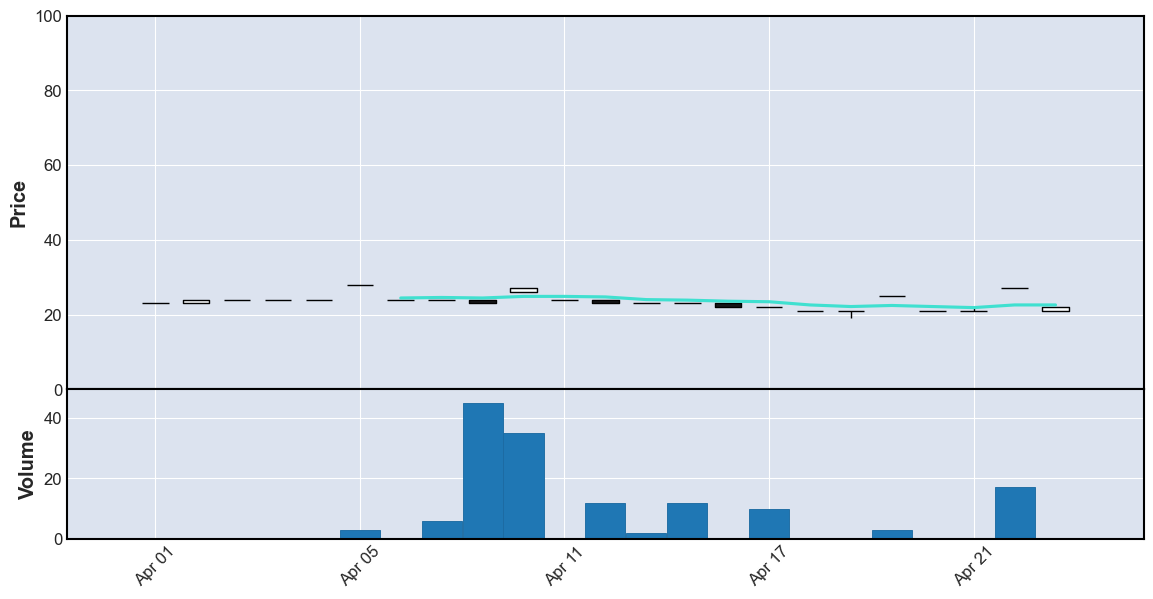

In [63]:
full_data = get_full_market_candlesticks(
    series_ticker="GTA6",
    ticker="GTA6-25JUN30",
    start_ts="04/01/2024",
    end_ts="04/24/2024",
    period_interval='m'
)

df = candlesticks_to_df(full_data)

cs_df = build_candlestick(full_data)
import mplfinance as mpf

fig, axes = mpf.plot(
    cs_df,
    type='candle',
    volume=True,
    figratio=(20, 10),
    figscale=1.3,
    show_nontrading=False,
    mav=7,
    returnfig=True
)

# Set y-axis limits for the price chart (first axes object)
axes[0].set_ylim(0, 100)  # customize as needed


In [223]:
df

,end_period,volume,open_interest,yes_bid_open,yes_bid_low,yes_bid_high,yes_bid_close,yes_ask_open,yes_ask_low,yes_ask_high,yes_ask_close,price_open,price_low,price_high,price_close,price_mean,price_previous
0,12/01/2023 00:00:00,0,0,75,0,90,79,100,87,100,89,NaN,NaN,NaN,NaN,NaN,NaN
1,12/02/2023 00:00:00,0,0,79,0,80,78,89,86,100,86,NaN,NaN,NaN,NaN,NaN,NaN
2,12/05/2023 00:00:00,810,810,78,0,79,38,86,44,100,44,52.0,44.0,52.0,49.0,46.0,NaN
3,12/06/2023 00:00:00,45,810,38,36,38,36,44,44,46,46,44.0,44.0,44.0,44.0,44.0,49.0
4,12/07/2023 00:00:00,0,810,36,0,37,37,46,44,100,44,NaN,NaN,NaN,NaN,NaN,44.0
5,12/10/2023 00:00:00,20,810,37,37,37,37,44,44,44,44,44.0,37.0,44.0,37.0,40.0,44.0
6,12/12/2023 00:00:00,0,810,37,0,37,36,44,43,100,43,NaN,NaN,NaN,NaN,NaN,37.0
7,12/13/2023 00:00:00,23,810,36,36,37,37,43,43,43,43,43.0,43.0,43.0,43.0,43.0,37.0
8,12/14/2023 00:00:00,0,810,37,37,37,37,43,42,47,43,NaN,NaN,NaN,NaN,NaN,43.0
9,12/15/2023 00:00:00,11,821,37,37,37,37,43,42,43,42,42.0,42.0,42.0,42.0,42.0,43.0
